## Train temporal models for mortality risk prediction

## Imports

In [1]:
import os
import random
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics

sys.path.append("..")
sys.path.append("../..")
from cyclops.utils.file import load_dataframe, save_dataframe
from drift_detection.baseline_models.static.pytorch.optimizer import Optimizer
from drift_detection.baseline_models.temporal.pytorch.utils import *

## Load train/val/test inputs and labels

In [2]:
DIR = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
split_type = "simulated_deployment"

X_train = np.load(os.path.join(DIR, split_type, "X_train.npy"))
X_val = np.load(os.path.join(DIR, split_type, "X_val.npy"))
X_test = np.load(os.path.join(DIR, split_type, "X_test.npy"))

y_train = np.load(os.path.join(DIR, split_type, "y_train.npy"))
y_val = np.load(os.path.join(DIR, split_type, "y_val.npy"))
y_test = np.load(os.path.join(DIR, split_type, "y_test.npy"))

print("Train set size:", X_train.shape[0])
print("Val set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

print("Num features:", X_train.shape[2])

Train set size: 9228
Val set size: 2308
Test set size: 5829
Num features: 108


In [3]:
unique, train_counts = np.unique(y_train, return_counts=True)
unique, val_counts = np.unique(y_val, return_counts=True)
unique, test_counts = np.unique(y_test, return_counts=True)
print(pd.DataFrame({'Train':train_counts,'Val': val_counts, 'Test':test_counts}, index=unique))

      Train   Val   Test
-1.0   8393  2065   5236
 0.0  31154  7932  19532
 1.0  15821  3851  10206


## Model and training configuration

In [6]:
output_dim = 1
batch_size = 64
input_dim = X_train.shape[2]
timesteps = X_train.shape[1]
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 256
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False

device = get_device()

X_train_inputs = X_train
X_val_inputs = X_val
X_test_inputs = X_test

train_dataset = get_data(X_train_inputs, y_train)
train_loader = train_dataset.to_loader(batch_size, shuffle=True)

val_dataset = get_data(X_val_inputs, y_val)
val_loader = val_dataset.to_loader(batch_size)

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
#os.chdir(os.path.join(os.getcwd(),"../../saved_models"))
#model_path = os.path.join(os.getcwd(),split_type+"_lstm.pt")
#model.load_state_dict(torch.load(model_path))

## Training and validation

[1/256] Training loss: 0.6271	 Validation loss: 0.6042
[2/256] Training loss: 0.5884	 Validation loss: 0.5855
[3/256] Training loss: 0.5734	 Validation loss: 0.5760
[4/256] Training loss: 0.5633	 Validation loss: 0.5675
[5/256] Training loss: 0.5543	 Validation loss: 0.5614
[6/256] Training loss: 0.5473	 Validation loss: 0.5587
[7/256] Training loss: 0.5425	 Validation loss: 0.5513
[8/256] Training loss: 0.5365	 Validation loss: 0.5485
[9/256] Training loss: 0.5340	 Validation loss: 0.5442
[10/256] Training loss: 0.5302	 Validation loss: 0.5428
[11/256] Training loss: 0.5262	 Validation loss: 0.5437
[12/256] Training loss: 0.5264	 Validation loss: 0.5386
[13/256] Training loss: 0.5243	 Validation loss: 0.5367
[14/256] Training loss: 0.5204	 Validation loss: 0.5355
[15/256] Training loss: 0.5185	 Validation loss: 0.5366
[16/256] Training loss: 0.5159	 Validation loss: 0.5338
[17/256] Training loss: 0.5152	 Validation loss: 0.5324
[18/256] Training loss: 0.5152	 Validation loss: 0.5309
[

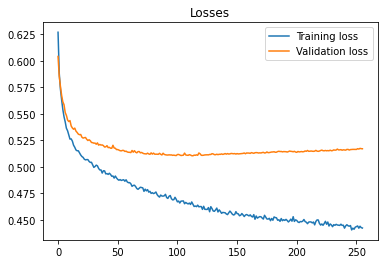

In [7]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=128, gamma=0.5)
activation = nn.Sigmoid()
opt = Optimizer(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    activation=activation,
    lr_scheduler=lr_scheduler,
)
opt.train(
     train_loader,
     val_loader,
     batch_size=batch_size,
     n_epochs=n_epochs,
     n_features=input_dim,
     timesteps=timesteps,
 )
opt.plot_losses()

## Validation metrics

[[6980  952]
 [1882 1969]]
confusion matrix:
[[6980  952]
 [1882 1969]]
accuracy = 0.7594839930534363
precision class 0 = 0.7876325845718384
precision class 1 = 0.6740842461585999
recall class 0 = 0.8799798488616943
recall class 1 = 0.5112957954406738
AUC of ROC = 0.793200641573866
AUC of PRC = 0.6827553389447604
min(+P, Se) = 0.6154245650480394
Precision: 0.7308584451675415
Recall: 0.6956378221511841


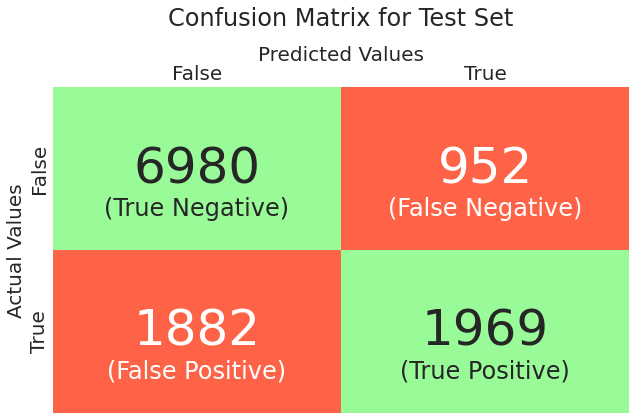

In [8]:
val_evaluate_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
y_val_labels, y_val_pred_values, y_val_pred_labels = opt.evaluate(
    val_evaluate_loader, batch_size=1, n_features=input_dim, timesteps=timesteps
)

y_val_pred_values = y_val_pred_values[y_val_labels != -1]
y_val_pred_labels = y_val_pred_labels[y_val_labels != -1]
y_val_labels = y_val_labels[y_val_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_val_labels, y_val_pred_labels)
print(confusion_matrix)

pred_metrics = print_metrics_binary(y_val_labels, y_val_pred_values, y_val_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")

def plot_pretty_confusion_matrix(confusion_matrix):
    sns.set(style='white')
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(np.eye(2), annot=confusion_matrix, fmt='g', annot_kws={'size': 50},
                cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
                yticklabels=['False', 'True'], xticklabels=['False', 'True'], ax=ax)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=20, length=0)

    ax.set_title('Confusion Matrix for Test Set', size=24, pad=20)
    ax.set_xlabel('Predicted Values', size=20)
    ax.set_ylabel('Actual Values', size=20)

    additional_texts = ['(True Negative)', '(False Negative)', '(False Positive)', '(True Positive)']
    for text_elt, additional_text in zip(ax.texts, additional_texts):
        ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
                ha='center', va='top', size=24)
    plt.tight_layout()
    plt.show()
    
plot_pretty_confusion_matrix(confusion_matrix)

## Testing metrics

In [9]:
test_dataset = get_data(X_test_inputs, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps
)

y_pred_values = y_pred_values[y_test_labels != -1]
y_pred_labels = y_pred_labels[y_test_labels != -1]
y_test_labels = y_test_labels[y_test_labels != -1]

confusion_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
print(confusion_matrix)

pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels)
prec = (pred_metrics["prec0"] + pred_metrics["prec1"]) / 2
rec = (pred_metrics["rec0"] + pred_metrics["rec1"]) / 2
print(f"Precision: {prec}")
print(f"Recall: {rec}")

[[17441  2091]
 [ 5441  4765]]
confusion matrix:
[[17441  2091]
 [ 5441  4765]]
accuracy = 0.7467213869094849
precision class 0 = 0.7622148394584656
precision class 1 = 0.6950116753578186
recall class 0 = 0.8929449319839478
recall class 1 = 0.46688222885131836
AUC of ROC = 0.7882165356988249
AUC of PRC = 0.6665902112840205
min(+P, Se) = 0.6183617479913777
Precision: 0.7286132574081421
Recall: 0.6799135804176331


## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names):
    confusion_matrix = (
        confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
    )

    layout = {
        "title": "Confusion Matrix",
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"},
    }

    fig = go.Figure(
        data=go.Heatmap(
            z=confusion_matrix,
            x=class_names,
            y=class_names,
            hoverongaps=False,
            colorscale="Greens",
        ),
        layout=layout,
    )
    fig.update_layout(height=512, width=1024)
    fig.show()


plot_confusion_matrix(
    confusion_matrix, ["low risk of mortality", "high risk of mortality"]
)

## Compute AUROC across timesteps

In [ ]:
y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
    test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps, flatten=False
)

num_timesteps = y_pred_labels.shape[1]
auroc_timesteps = []
for i in range(num_timesteps):
    labels = y_test_labels[:, i]
    pred_vals = y_pred_values[:, i]
    preds = y_pred_labels[:, i]
    pred_vals = pred_vals[labels != -1]
    preds = preds[labels != -1]
    labels = labels[labels != -1]
    pred_metrics = print_metrics_binary(labels, pred_vals, preds, verbose=False)
    auroc_timesteps.append(pred_metrics["auroc"])


prediction_hours = list(range(24, 168, 24))
fig = go.Figure(
    data=[go.Bar(x=prediction_hours, y=auroc_timesteps, name="model confidence")]
)

fig.update_xaxes(tickvals=prediction_hours)
fig.update_yaxes(range=[min(auroc_timesteps) - 0.05, max(auroc_timesteps) + 0.05])

fig.update_layout(
    title="AUROC split by no. of hours after admission",
    autosize=False,
    xaxis_title="No. of hours after admission",
)
fig.show()

## WIP: Compute accuracy across lead times

In [ ]:
# BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/risk_of_mortality"

# combined_events = load_dataframe(os.path.join(BASE_DATA_PATH, "combined_events"))
# timestep_end_timestamps = load_dataframe(os.path.join(BASE_DATA_PATH, "aggmeta_end_ts"))

# mortality_events = combined_events.loc[combined_events["event_name"] == "death"]

# y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
#     test_loader, batch_size=1, n_features=input_dim, timesteps=timesteps, flatten=False
# )
# train_val_test_ids = load_dataframe(os.path.join(BASE_DATA_PATH, "train_val_test_ids"))
# test_ids = train_val_test_ids["test"].dropna()

# num_timesteps = y_pred_labels.shape[1]
# acc_timesteps = []
# for timestep in range(num_timesteps):
#     labels = y_test_labels[:, timestep]
#     pred_vals = y_pred_values[:, timestep]
#     preds = y_pred_labels[:, timestep]

#     is_correct_timestep = []
#     for enc_id in test_ids:
#         timestep_end_timestamp = timestep_end_timestamps.loc[enc_id, timestep]
#         mortality_timestamp = mortality_events.loc[mortality_events["encounter_id"] == enc_id]["discharge_timestamp"]
#         lead_time = mortality_timestamp - timestep_end_timestamp
#         print(timestep_end_timestamp, mortality_timestamp)
#         if (lead_time > pd.to_timedelta(0, unit="h")).all():
#             label_ = labels[test_ids.index(enc_id)]
#             pred_ = preds[test_ids.index(enc_id)]

#             if label_ == 1:
#                 if label_ == pred_:
#                     is_correct_timestep.append(1)
#                 else:
#                     is_correct_timestep.append(0)

#     acc_timesteps.append(sum(is_correct_timestep) / len(is_correct_timestep))

## Visualize model outputs and labels

In [ ]:
def plot_risk_mortality(predictions, labels=None):
    prediction_hours = list(range(24, 168, 24))
    is_mortality = labels == 1
    after_discharge = labels == -1
    label_h = -0.2
    fig = go.Figure(
        data=[
            go.Scatter(
                mode="markers",
                x=prediction_hours,
                y=[label_h for x in prediction_hours],
                line=dict(color="Black"),
                name="low risk of mortality label",
                marker=dict(color="Green", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(is_mortality) if v],
                y=[label_h for _, v in enumerate(is_mortality) if v],
                line=dict(color="Red"),
                name="high risk of mortality label",
                marker=dict(color="Red", size=20, line=dict(color="Black", width=2)),
            ),
            go.Scatter(
                mode="markers",
                x=[prediction_hours[i] for i, v in enumerate(after_discharge) if v],
                y=[label_h for _, v in enumerate(after_discharge) if v],
                line=dict(color="Grey"),
                name="post discharge label",
                marker=dict(color="Grey", size=20, line=dict(color="Black", width=2)),
            ),
            go.Bar(
                x=prediction_hours,
                y=predictions,
                marker_color="Red",
                name="model confidence",
            ),
        ]
    )
    fig.update_yaxes(range=[label_h, 1])
    fig.update_xaxes(tickvals=prediction_hours)
    fig.update_xaxes(showline=True, linewidth=2, linecolor="black")

    fig.add_hline(y=0.5)

    fig.update_layout(
        title="Model output visualization",
        autosize=False,
        xaxis_title="No. of hours after admission",
        yaxis_title="Model confidence",
    )

    return fig


mortality_cases = [idx for idx, v in enumerate(y_test_labels)]
sample_idx = random.choice(mortality_cases)
fig = plot_risk_mortality(
    y_pred_values[sample_idx].squeeze(), y_test_labels[sample_idx]
)
fig.show()

## Journal of some experiments


<table>
    <thead>
        <tr>
            <th>Split</th>
            <th>Model</th>
            <th>AUROC</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=4>Random</td>
        </tr>
        <tr>
            <td>LSTM</td>
            <td><b>0.8005</b></td>
        </tr>
          <tr style="border-bottom:1px solid black">
            <td colspan="100%"></td>
          </tr>
          <tr> ... </tr>
    </tbody>
</table>